In [17]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from deepxde.callbacks import ModelCheckpoint
from deepxde.callbacks import Callback

In [18]:
# Set random seed
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
dde.backend.tf.random.set_random_seed(seed)

# Set hyperparameters
n_output = 3 # postition (x), theta, force on cart (u_norm)

num_domain = 1000

n_adam = 5000

lr = 2e-2 # for Adam
loss_weights = [1., 1., 1., 1., 1., 1, 1., 1.]

# Set physical parameters
tmin, tmax = 0.0, 10.0
# xmin, xmax = -5.0, 5.0
target = -1. # cos(theta) should be close to 180 degrees

# Define constants
M = 2 # Mass of the cart
m = 1 # Mass of the pendulum
b = 0.1 # Friction coefficient
I = 0.33 # Moment of inertia
g = 9.8 # Gravity
l = 1 # Length of the pendulum
force_max = 25  # Maximum force

In [19]:
class Custom_BC(dde.icbc.BC):
    def __init__(self, geom, func, on_boundary, component=0):
        super().__init__(geom, on_boundary, component)
        self.func = dde.icbc.boundary_conditions.npfunc_range_autocache(dde.utils.return_tensor(func))
        
    def error(self, X, inputs, outputs, beg, end, aux_var=None):
        # beg and end specify the current batch range
        values = self.func(X, beg, end, aux_var)
        theta = outputs[:, 1:2]
        goal = tf.cos(theta)
        return (goal[beg:end, self.component:self.component + 1] - values) ** 2

In [20]:
def ode(t, u):
    x, theta, force_norm = u[:, 0:1], u[:, 1:2], tf.tanh(u[:, 2:3])
    force = force_max * force_norm
    x_dot = dde.grad.jacobian(x, t)
    theta_dot = dde.grad.jacobian(theta, t)
    x_ddot = dde.grad.jacobian(x_dot, t)
    theta_ddot = dde.grad.jacobian(theta_dot, t)

    denominator = I * (M + m) + M * m * l * l

    res1 = x_ddot - (((-(I + m * l * l) * b * x_dot) + (m * m * g * l * l * theta) + ((I + m * l * l) * force)) / denominator)
    res2 = theta_ddot - (((-m * b * l * theta_dot) + (m * g * (M + m) * l * theta) +( m * l * force)) / denominator)

    return [res1, res2]

In [21]:
def initial(_, on_initial):
    return on_initial

def boundary_left(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmin) checks if the point is on the left boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmin)

def boundary_right(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmax) checks if the point is on the right boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmax)

In [22]:
geom = dde.geometry.TimeDomain(tmin, tmax)

# INITIAL CONDITIONS
position_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=0) # posittion = 0 at time = 0
theta_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=1) # theta = 0 at time = 0
force_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=2) # force = 0 at time = 0

# NEUMANN CONDITIONS
velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=0) # cart velocity = 0 at time = 0
angular_velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=1) # angular velocity 1 = 0 at time = 0

# CUSTOM BOUNDARY CONDITIONS - GOAL AND POSITION RANGE
goal = Custom_BC(geom, lambda t: np.array([target]), boundary_right) # custom ICBC

losses = [position_initial, theta_initial, force_initial, velocity_initial, angular_velocity_initial, goal]

data = dde.data.PDE(geom, ode, losses, num_domain=num_domain, num_boundary=5)
# dataset size here will be 1002 (1000 domain + 2 boundary)

In [23]:
net = dde.nn.FNN([1] + [64] * 3 + [n_output], "tanh", "Glorot normal")

In [24]:
resampler = dde.callbacks.PDEPointResampler(period=100)

In [25]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, loss_weights=loss_weights)

Compiling model...
Building feed-forward neural network...
'build' took 0.041280 s



'compile' took 0.400934 s



In [26]:
# class PrintOutputsCallback(Callback):
#     def __init__(self, data):
#         super(PrintOutputsCallback, self).__init__()
#         self.data = data  # Data used for prediction (e.g., time or spatial points)

#     def on_epoch_end(self):
#         predictions = model.predict(self.data)
#         print("Model predictions at the end of epoch:", predictions[-1])

# time = np.linspace(tmin, tmax, num_domain)
# time = time.reshape(-1, 1)

# # Create an instance of the callback
# print_outputs_callback = PrintOutputsCallback(time)

In [27]:
model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/best_model.ckpt',  # Path to save the model file
    monitor='test loss',          # Monitor the validation loss
    save_better_only=True          # Only save when the monitored quantity (val_loss) has improved
)

In [28]:
print("Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal")
losshistory, train_state = model.train(display_every=10, iterations=n_adam, callbacks=[resampler, model_checkpoint])
# losshistory, train_state = model.train(display_every=100, iterations=n_adam, callbacks=[print_outputs_callback])

Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [7.89e-01, 3.33e-01, 0.00e+00, 0.00e+00, 0.00e+00, 9.20e-02, 1.18e-02, 1.60e+01]    [7.89e-01, 3.33e-01, 0.00e+00, 0.00e+00, 0.00e+00, 9.20e-02, 1.18e-02, 1.60e+01]    []  
INFO:tensorflow:checkpoints/best_model.ckpt-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
10        [3.03e+01, 6.76e+01, 1.44e-02, 1.46e-01, 1.80e+00, 6.19e-02, 3.48e+00, 4.09e-01]    [3.03e+01, 6.76e+01, 1.44e-02, 1.46e-01, 1.80e+00, 6.19e-02, 3.48e+00, 4.09e-01]    []  
20        [4.80e+01, 3.17e+01, 2.66e-01, 5.86e-02, 1.42e-01, 4.58e-01, 5.86e-02, 1.60e+01]    [4.80e+01, 3.17e+01, 2.66e-01, 5.86e-02, 1.42e-01, 4.58e-01, 5.86e-02, 1.60e+01]    []  
30   

## Getting the predictions for time = 0 to time = 10 at intervals of 0.01

In [14]:
model.restore(save_path='checkpoints/best_model.ckpt-4420.ckpt')

t = np.linspace(tmin, tmax, 101)
predictions = model.predict(np.array([t]).T)
predictions[:, 2] = np.tanh(predictions[:, 2]) * force_max

predictions.shape

INFO:tensorflow:Restoring parameters from checkpoints/best_model.ckpt-4420.ckpt


(101, 3)

In [15]:
np.save('single_inverted_cart_outputs.npy', predictions)
predictions

array([[-1.07049942e-04, -9.08691436e-05, -2.01314688e-03],
       [-9.46521759e-05, -8.72891396e-05, -2.08076090e-03],
       [-8.38786364e-05, -8.42958689e-05, -2.14353204e-03],
       [-7.42077827e-05, -8.17049295e-05, -2.19307840e-03],
       [-6.57439232e-05, -7.93952495e-05, -2.23331153e-03],
       [-5.83976507e-05, -7.74376094e-05, -2.27820128e-03],
       [-5.20199537e-05, -7.57090747e-05, -2.30725855e-03],
       [-4.61488962e-05, -7.42189586e-05, -2.32886523e-03],
       [-4.09036875e-05, -7.28797168e-05, -2.36351043e-03],
       [-3.59714031e-05, -7.18068331e-05, -2.36872584e-03],
       [-3.16500664e-05, -7.05681741e-05, -2.38772482e-03],
       [-2.76565552e-05, -6.96890056e-05, -2.39815563e-03],
       [-2.42292881e-05, -6.89607114e-05, -2.41268426e-03],
       [-2.09957361e-05, -6.81262463e-05, -2.42609531e-03],
       [-1.76578760e-05, -6.73346221e-05, -2.43987888e-03],
       [-1.46031380e-05, -6.67832792e-05, -2.44658440e-03],
       [-1.21891499e-05, -6.61294907e-05

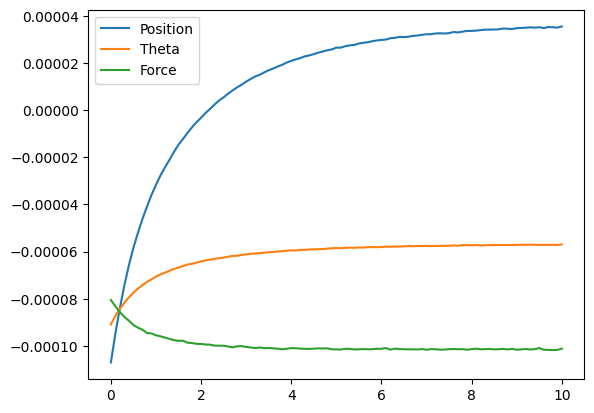

In [16]:
t = np.linspace(tmin, tmax, 101)
uu = model.predict(np.array([t]).T)
plt.plot(t, uu[:, 0])
plt.plot(t, np.tanh(uu[:, 1]))
plt.plot(t, np.tanh(uu[:, 2]))
plt.legend(["Position", "Theta", "Force"])
plt.show()